# Ripple NRTidal verification notebook

**Abstract:** Here, we will write code that checks the implementation written for the NRTidal project.

*To Do:* 
- Check if we can verify with LAL instead of Bilby, since that's also done in the original ripple paper.
- Getting NaNs for equal mass?

In [280]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from jax import grad, vmap
from functools import partial
import importlib

import bilby

# To get the relevant plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

We will compare waveforms with the following intrinsic parameters:

In [281]:
m1 = 50.0 # masses
m2 = 40.0

chi1 = 0.5 # spins
chi2 = -0.5

lambda1 = 0 # tidal deformabilities
lambda2 = 0

distance = 50.

## Ripple

In [282]:
from ripple.waveforms import X_NRTidalv2
importlib.reload(X_NRTidalv2)

<module 'ripple.waveforms.X_NRTidalv2' from '/Users/Woute029/Documents/Code/ripple/src/ripple/waveforms/X_NRTidalv2.py'>

In [283]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0.0 
phic = 0.0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination, polarization_angle])

f_l = 24.
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)

# We also need to give a reference frequency - here, this will be the lower frequency
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs, theta_ripple, f_ref, "IMRPhenomD")

0.0


## Bilby

In [284]:
injection_parameters = dict(
    mass_1 = m1, 
    mass_2 = m2, 
    
    chi_1 = chi1,  
    chi_2 = chi2, 
    
    lambda_1 = lambda1,
    lambda_2 = lambda2,
    
    ra = 0.0, 
    dec = 0.0, 
    luminosity_distance = distance, 
    theta_jn = 0., 
    psi = 0., 
    geocent_time = 0., 
    phase = 0., 
)

In [285]:
## NOTE - is this OK?
duration = 8
sampling_frequency = 1024
start_time = injection_parameters["geocent_time"] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomD_NRTidalv2",
    reference_frequency=f_ref,
    minimum_frequency=f_l,
)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

polas_bilby = waveform_generator.frequency_domain_strain(injection_parameters)
hp_bilby, hc_bilby = polas_bilby['plus'], polas_bilby['cross']

15:10 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


## Comparison

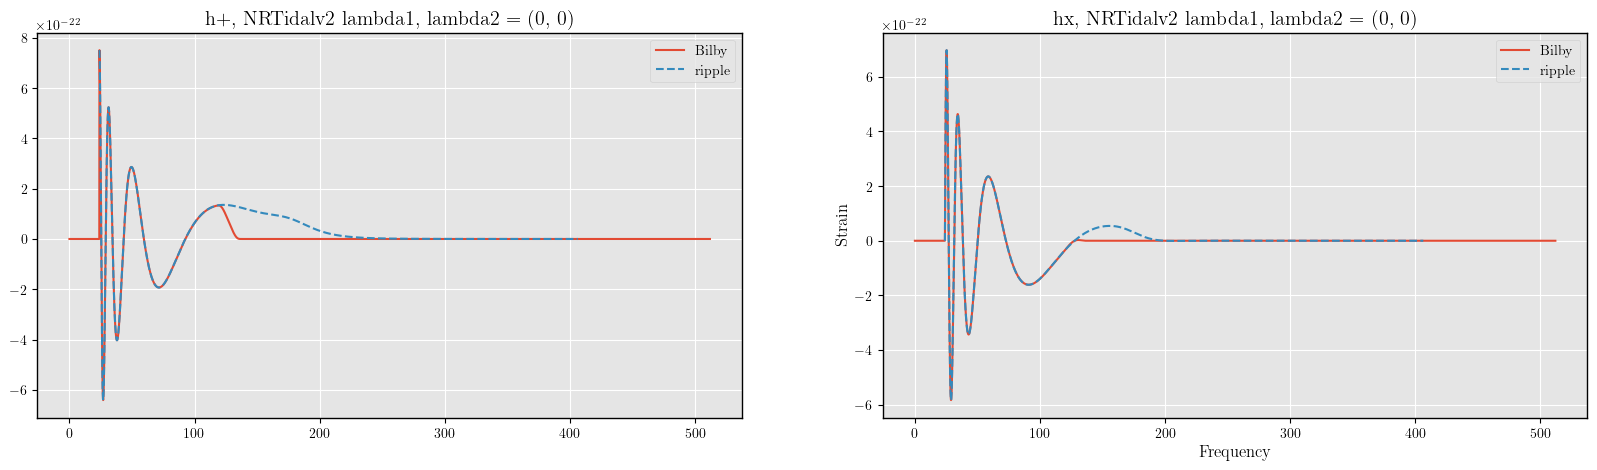

In [286]:
a = 1
plt.subplots(1, 2, figsize=(20, 5))
plt.subplot(1, 2, 1)

plt.plot(waveform_generator.frequency_array, hp_bilby.real, "-", label = "Bilby", alpha = a)
plt.plot(fs, hp_ripple.real, "--", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(waveform_generator.frequency_array, hc_bilby.real, "-", label = "Bilby", alpha = a)
plt.plot(fs, hc_ripple.real, "--", label = "ripple", alpha = a)

plt.legend()
plt.title(f"hx, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

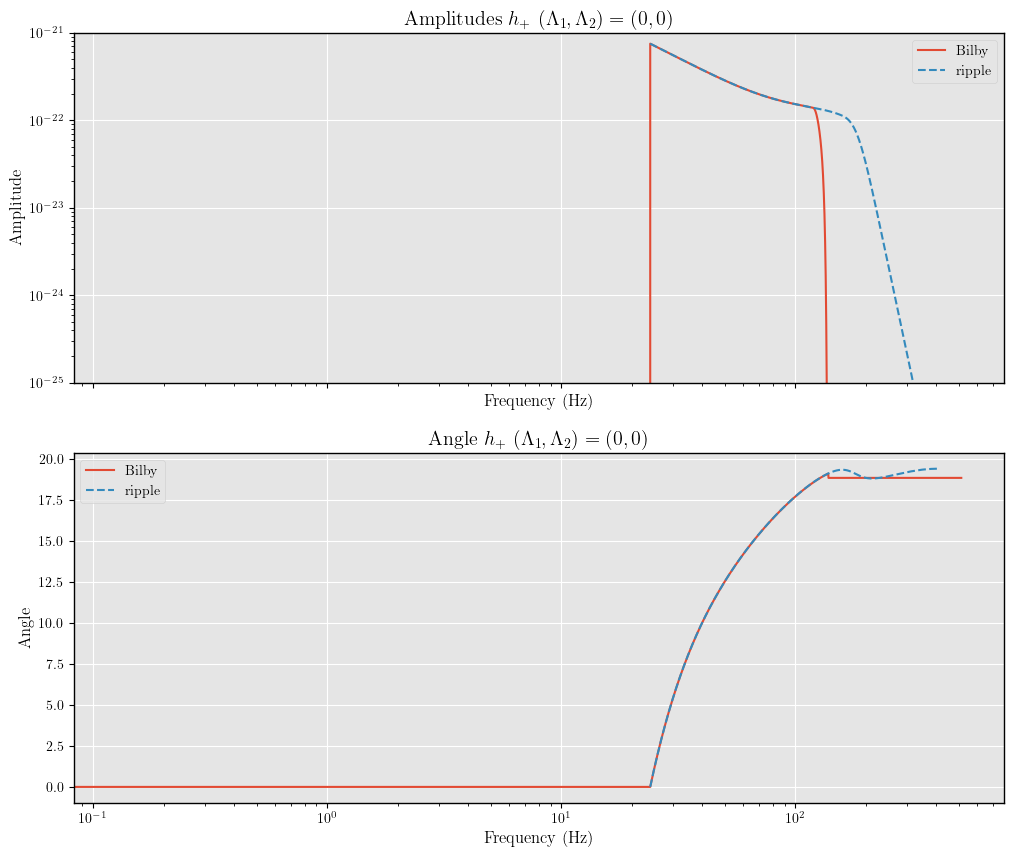

In [287]:
A_bilby = jnp.abs(hp_bilby)
angle_bilby = np.unwrap(np.angle(hp_bilby))

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))


plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

plt.plot(waveform_generator.frequency_array, A_bilby, "-", label = "Bilby", alpha = a)
plt.plot(fs, A_ripple, "--", label = "ripple", alpha = a)
plt.title(r"Amplitudes $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-25, 1e-21)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(waveform_generator.frequency_array, angle_bilby, "-", label = "Bilby", alpha = a)
plt.plot(fs, angle_ripple, "--", label = "ripple", alpha = a)
plt.legend()
plt.title(r"Angle $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Angle")
plt.xscale('log')
plt.show()

## Bridging the gap between the two implementations

There is a difference between the two waveforms. 

About the amplitude:
- Seems to go wrong for higher amplitudes? The lower frequency modes match correctly.
- Have to implement the Planck taper

About the phase:
- Corrections coming from SS seem to go very wrong? These are definitely wrong?
- Without SS corrections, wrong pattern, wrong power law?

### Amplitude

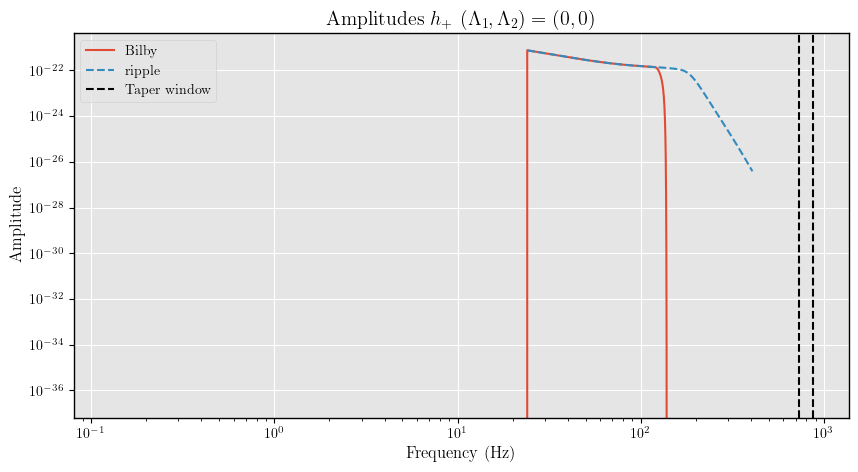

In [288]:
# Get the tidal contribution only:
theta = jnp.array([m1, m2, chi1, chi2, lambda1, lambda2])
kappa = X_NRTidalv2.get_kappa_eff(theta)

# Get the tidal amplitude
tidal = X_NRTidalv2.get_tidal_amplitude(fs, theta, kappa, dL=distance)
# Get the frequency of the merger, to check where taper window would come
f_merger = X_NRTidalv2._get_f_merger(theta, kappa)


plt.figure(figsize=(10, 5))
plt.plot(waveform_generator.frequency_array, A_bilby, "-", label = "Bilby", alpha = a)
plt.plot(fs, A_ripple, "--", label = "ripple", alpha = a)

plt.axvline(f_merger, ls="--", color="black", label = "Taper window")
plt.axvline(1.2 * f_merger, ls="--", color="black")

# plt.plot(fs, tidal, "-", color="black", label="$A_T$")

plt.title(r"Amplitudes $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-25, 1e-21)
plt.legend()
plt.show()

In [289]:
print(f_merger)

728.0489
